# Parastoo Javadi 4/19/21
## Project outline
### Seattle's air traffic forecast for 2021 amid covid pandemic.


[Dataset source:](https://zenodo.org/record/4670228#.YH1FdxNKhb9)
DataFrame attributes description :

Description of the dataset

One file per month is provided as a csv file with the following features:

callsign: the identifier of the flight displayed on ATC screens (usually the first three letters are reserved for an 
airline: AFR for Air France, DLH for Lufthansa, etc.)

number: the commercial number of the flight, when available (the matching with the callsign comes from public open API)

icao24: the transponder unique identification number;

registration: the aircraft tail number (when available);

typecode: the aircraft model type (when available);

origin: a four letter code for the origin airport of the flight (when available);

destination: a four letter code for the destination airport of the flight (when available);

firstseen: the UTC timestamp of the first message received by the OpenSky Network;

lastseen: the UTC timestamp of the last message received by the OpenSky Network;

day: the UTC day of the last message received by the OpenSky Network;

latitude_1, longitude_1, altitude_1: the first detected position of the aircraft;

latitude_2, longitude_2, altitude_2: the last detected position of the aircraft.

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import matplotlib

### Upload csv files then concatenate them all in one dataframe

In [3]:
# Add the new data available in 2021

path = '/home/parastooj/Downloads/flights/'
files = [file for file in Path(path).glob("flightlist_*.csv.gz")]

newdf = pd.concat(pd.read_csv(file) for file in files)

# change the index of the dataframe to a datatime format for timeseries analysis 

df21 = newdf[(newdf.origin=='KSEA') | (newdf.destination=='KSEA')]

In [4]:
# Get the flights that are originated from Seattle or their destination from previously cleaned and filthered csv files

df1 = pd.read_csv('/home/parastooj/Downloads/flights/seattle_flights_2019_2.csv', index_col=0)
df2 = pd.read_csv('/home/parastooj/Downloads/flights/seattle_flights_2020.csv', index_col=0)

# Concatenate all years data in one dataframe

df3 = pd.concat([df1,df2, df21])

# change the index of the dataframe to a datatime format for timeseries analysis 

dates = pd.DatetimeIndex(df3.day)
df3['dates'] = dates.date
df3['year'] = dates.year
df3['dayofyear'] = dates.dayofyear
df3['month']=dates.month
df3['week'] = dates.week
df3['count'] = 1

def plot_airtraffic(freq='month'):
    df19 = df3[df3.year==2019]
    df20 = df3[df3.year==2020]
    df21 = df3[df3.year==2021]
    df19.groupby(freq).sum()['count'].plot(label='2019 flights')
    df20.groupby(freq).sum()['count'].plot(label='2020 flights')
    df21.groupby(freq).sum()['count'].plot(label='2021 flights')
    plt.legend()
    if freq=='day':
        plt.title('Covid Effect on the daily air traffic of Seattle'.format(freq))
    else:
        plt.title('Covid Effect on the {}ly air traffic of Seattle'.format(freq))
    plt.show()


/home/parastooj/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/parastooj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Comparison of Seattle Air Traffic between Jan 2019 to Apr 2021

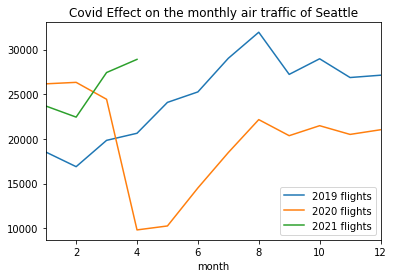

In [5]:
plot_airtraffic(freq='month')

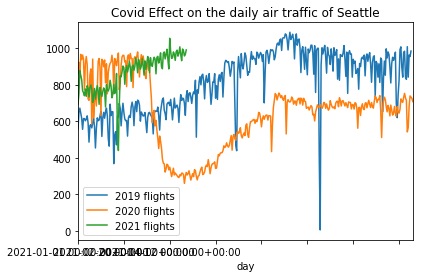

In [6]:
plot_airtraffic(freq='day')

## Jan 2019 - Apr 2021 Seattle Air Traffic

Text(0.5, 1.0, 'Changes in Seattle Air Traffic Jan 2019 - Apr 2021')

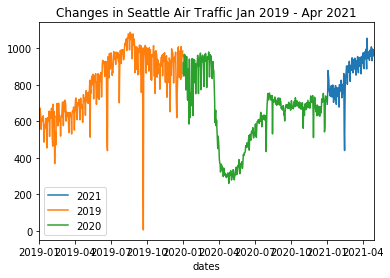

In [7]:
df19 = df3[df3.year==2019]
df20 = df3[df3.year==2020]
df21 = df3[df3.year==2021]
df21.groupby('dates').sum()['count'].plot(label='2021')
df19.groupby('dates').sum()['count'].plot(label='2019')
df20.groupby('dates').sum()['count'].plot(label='2020')
plt.legend()
plt.title('Changes in Seattle Air Traffic Jan 2019 - Apr 2021')

## Observations from Auto Correlation Function (ACF) Plots

The strongest correlation is with the most recent value. This is typical with time series.

During 2019, there is a strong negative correlation around 26 weeks. 

However this pattern has changed during 2020 (Covid19 effect) and strong negative correlation happens earliear around 12 weeks. 


Text(0.5, 1.0, 'Auto Correlation Function 2019')

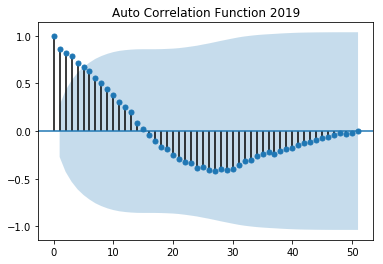

In [8]:
df19 = df3[df3.year==2019]
plot_acf(df19.groupby('week').sum()['count']);
plt.title('Auto Correlation Function 2019')

Text(0.5, 1.0, 'Auto Correlation Function 2020')

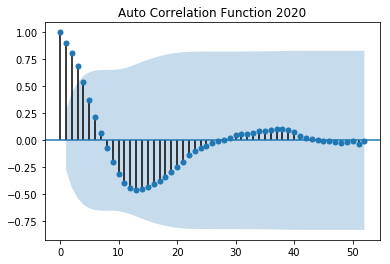

In [9]:
df20 = df3[df3.year==2020]
plot_acf(df20.groupby('week').sum()['count']);
plt.title('Auto Correlation Function 2020')

## Extracting Seasonal and Trend features from the dataset using statsmodels

There should be more data available to make the trend better fit the lenght of the dataset. The data from opensky network has surveillance of flights since 2013. [OpenSky](https://opensky-network.org/) 

The extracted trend from below analysis shows an overall decrease in number of flights in 2020 as an effect of covid. However, the trend turns upward toward the end of 2020 and the beginning of 2021.

In [10]:
df7 = pd.DataFrame(df3.groupby('dates').sum()['count'])
df7.reset_index(inplace=True)
df8 = df7.set_index('dates').asfreq('w')
df8.replace(np.nan, 0, inplace=True)

decomposed = sm.tsa.seasonal_decompose(df8)

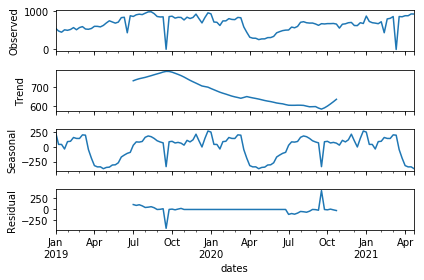

In [11]:
fig = decomposed.plot()
matplotlib.rcParams['figure.figsize'] = [9, 5]

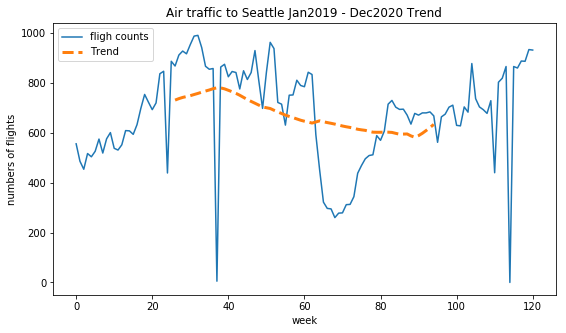

In [12]:
fig = plt.figure()
plt.plot(np.array(df8), label='fligh counts')
plt.plot(np.array(decomposed.trend), linewidth=3, linestyle='--', label='Trend')
plt.legend()
plt.xlabel('week')
plt.ylabel('numbers of flights')
plt.title('Air traffic to Seattle Jan2019 - Dec2020 Trend');

Conclusion of Analysis:
    
    Around 4.3 GB data was analyzed 

## Seasonal AutoRegressive Integrated Moving Averages

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
data = df7.set_index('dates').asfreq('w')

train = data[data.index<'2021-01-03']
test = data[data.index>='2021-01-03']

# fit model
model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

yhat = model_fit.predict(test.index[0], test.index[-1])
print(yhat)

2021-01-03    666.707640
2021-01-10    650.803919
2021-01-17    635.279568
2021-01-24    620.125536
2021-01-31    605.332991
2021-02-07    590.893308
2021-02-14    576.798071
2021-02-21    563.039064
2021-02-28    549.608266
2021-03-07    536.497847
2021-03-14    523.700166
2021-03-21    511.207762
2021-03-28    499.013354
2021-04-04    487.109832
2021-04-11    475.490258
2021-04-18    464.147859
2021-04-25    453.076023
Freq: W-SUN, dtype: float64


/home/parastooj/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


## Autoregressive Integrated Moving Average ARIMA(p,d,q) Model

Text(0.5, 1.0, 'SARIMAX Prediction')

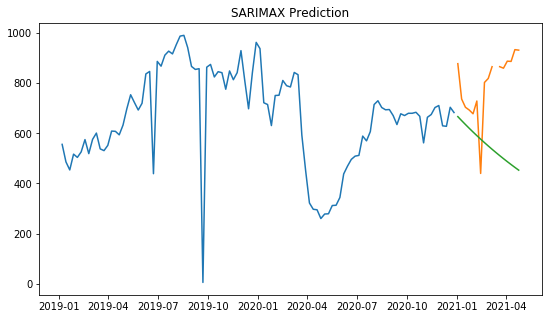

In [19]:
plt.plot(train)
plt.plot(test)
plt.plot(yhat)
plt.title('SARIMAX Prediction')

In [23]:
from statsmodels.tsa import arima_model

In [31]:
model = arima_model.ARIMA(train, order=(4, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(test.index[0], test.index[-1])
print(yhat)

2021-01-03    687.657372
2021-01-10    700.125856
2021-01-17    701.941928
2021-01-24    705.689276
2021-01-31    709.630231
2021-02-07    711.901958
2021-02-14    713.835540
2021-02-21    715.301947
2021-02-28    716.152232
2021-03-07    716.564995
2021-03-14    716.568783
2021-03-21    716.188005
2021-03-28    715.479142
2021-04-04    714.481622
2021-04-11    713.232512
2021-04-18    711.770222
2021-04-25    710.129411
Freq: W-SUN, dtype: float64


Text(0.5, 1.0, 'ARIMA Prediction')

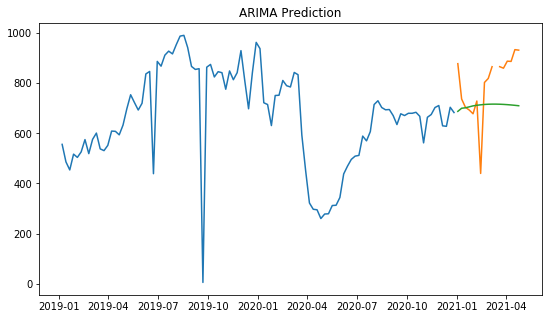

In [32]:
plt.plot(train)
plt.plot(test)
plt.plot(yhat)
plt.title('ARIMA Prediction')